# Exploratory Data Analysis - Brent Oil Prices

**Project:** Brent Oil Change Point Analysis  
**Objective:** Analyze Brent oil price data to understand trends, volatility, and prepare for Bayesian change point modeling

## Overview

This notebook performs initial exploratory data analysis on historical Brent oil prices from May 1987 to November 2022. The analysis includes:

1. Data loading and validation
2. Summary statistics
3. Price trend visualization
4. Log returns analysis
5. Volatility patterns
6. Stationarity testing

**Key Question:** Are the price series and returns stationary? This determines whether we can proceed with change point modeling.

## 1. Setup and Imports

In [1]:
# Standard library imports
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data processing
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Add project directory to Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import project modules
from src.data.loader import BrentDataLoader
from src.data.event_loader import EventDataLoader
from src.eda.time_series_analysis import TimeSeriesAnalyzer
from src.statistical_tests.stationarity import StationarityTester

# Create figures directory if it doesn't exist
figures_dir = Path('../reports/figures')
figures_dir.mkdir(parents=True, exist_ok=True)

print("✓ All imports successful")
print(f"✓ Figures directory: {figures_dir.absolute()}")

✓ All imports successful
✓ Figures directory: /home/voldi/Projects/ai-ml/brent-oil-change-point-analysis/notebooks/../reports/figures


## 2. Data Loading

Load both the Brent oil price data and the event data we compiled.

In [2]:
# Load Brent oil price data
loader = BrentDataLoader()
data = loader.load_data('../data/raw/BrentOilPrices.csv')

# Display basic information
print("=" * 70)
print("BRENT OIL PRICE DATA")
print("=" * 70)
date_range = loader.get_date_range()
print(f"Date range: {date_range[0].date()} to {date_range[1].date()}")
print(f"Total observations: {len(data):,}")
print(f"\nFirst few rows:")
print(data.head())
print(f"\nLast few rows:")
print(data.tail())
print(f"\nData shape: {data.shape}")
print(f"Columns: {list(data.columns)}")

BRENT OIL PRICE DATA
Date range: 1987-05-20 to 2022-11-14
Total observations: 9,011

First few rows:
            Price
Date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63

Last few rows:
            Price
Date             
2022-11-08  96.85
2022-11-09  93.05
2022-11-10  94.25
2022-11-11  96.37
2022-11-14  93.59

Data shape: (9011, 1)
Columns: ['Price']


In [3]:
# Load event data
event_loader = EventDataLoader()
events = event_loader.load_events('../data/events.csv')

# Get event summary
event_summary = event_loader.get_events_summary()

print("=" * 70)
print("EVENT DATA")
print("=" * 70)
print(f"Total events: {event_summary['total_events']}")
print(f"Date range: {event_summary['date_range'][0]} to {event_summary['date_range'][1]}")

print("\nEvents by type:")
for event_type, count in event_summary['by_type'].items():
    print(f"  {event_type}: {count}")

print("\nEvents by expected impact:")
for impact, count in event_summary['by_impact'].items():
    print(f"  {impact}: {count}")

print("\nSample events:")
print(events[['date', 'event_name', 'event_type', 'expected_impact']].head(8))

EVENT DATA
Total events: 17
Date range: 1990-08-02 to 2022-02-24

Events by type:
  geopolitical: 6
  economic_shock: 6
  opec_decision: 4
  sanction: 1

Events by expected impact:
  increase: 11
  decrease: 6

Sample events:
        date                event_name      event_type expected_impact
0 1990-08-02   Iraq Invasion of Kuwait    geopolitical        increase
1 1991-01-17           Gulf War Begins    geopolitical        increase
2 1997-07-02    Asian Financial Crisis  economic_shock        decrease
3 1998-03-30  OPEC Production Increase   opec_decision        decrease
4 2001-09-11      September 11 Attacks    geopolitical        decrease
5 2002-12-02      Venezuela Oil Strike  economic_shock        increase
6 2003-03-20           Iraq War Begins    geopolitical        increase
7 2008-07-11            Oil Price Peak  economic_shock        increase


## 3. Summary Statistics

Calculate comprehensive statistics for both prices and returns.

In [4]:
# Create analyzer
analyzer = TimeSeriesAnalyzer(data)

# Get comprehensive statistics
stats = analyzer.get_summary_statistics()

print("=" * 70)
print("PRICE STATISTICS")
print("=" * 70)
print(f"Count: {stats['data_info']['count']:,} observations")
print(f"Date range: {stats['data_info']['date_range'][0]} to {stats['data_info']['date_range'][1]}")
print(f"\nPrice (USD/barrel):")
print(f"  Mean:    ${stats['price_stats']['mean']:.2f}")
print(f"  Median:  ${stats['price_stats']['median']:.2f}")
print(f"  Std Dev: ${stats['price_stats']['std']:.2f}")
print(f"  Min:     ${stats['price_stats']['min']:.2f}")
print(f"  Max:     ${stats['price_stats']['max']:.2f}")
print(f"  25th %:  ${stats['price_stats']['percentile_25']:.2f}")
print(f"  75th %:  ${stats['price_stats']['percentile_75']:.2f}")

print(f"\n" + "=" * 70)
print("RETURNS STATISTICS")
print("=" * 70)
print(f"Mean daily return: {stats['returns_stats']['mean_return']:.6f} ({stats['returns_stats']['mean_return']*100:.4f}%)")
print(f"Daily volatility:  {stats['returns_stats']['volatility']:.6f} ({stats['returns_stats']['volatility']*100:.4f}%)")
print(f"Skewness:          {stats['returns_stats']['skewness']:.4f}")
print(f"Kurtosis:          {stats['returns_stats']['kurtosis']:.4f}")

print("\nInterpretation:")
if stats['returns_stats']['skewness'] < -0.5:
    print("  • Negative skewness indicates left tail (more extreme negative returns)")
elif stats['returns_stats']['skewness'] > 0.5:
    print("  • Positive skewness indicates right tail (more extreme positive returns)")
else:
    print("  • Approximately symmetric distribution")
    
if stats['returns_stats']['kurtosis'] > 3:
    print(f"  • High kurtosis ({stats['returns_stats']['kurtosis']:.1f}) indicates fat tails (extreme events)")

PRICE STATISTICS
Count: 9,011 observations
Date range: 1987-05-20 to 2022-11-14

Price (USD/barrel):
  Mean:    $48.42
  Median:  $38.57
  Std Dev: $32.86
  Min:     $9.10
  Max:     $143.95
  25th %:  $19.05
  75th %:  $70.09

RETURNS STATISTICS
Mean daily return: 0.000179 (0.0179%)
Daily volatility:  0.025532 (2.5532%)
Skewness:          -1.7444
Kurtosis:          65.9047

Interpretation:
  • Negative skewness indicates left tail (more extreme negative returns)
  • High kurtosis (65.9) indicates fat tails (extreme events)


## 4. Price Series Visualization

Visualize the raw price series over time to identify trends and structural breaks.

✓ Figure saved: ../reports/figures/01_price_series.png


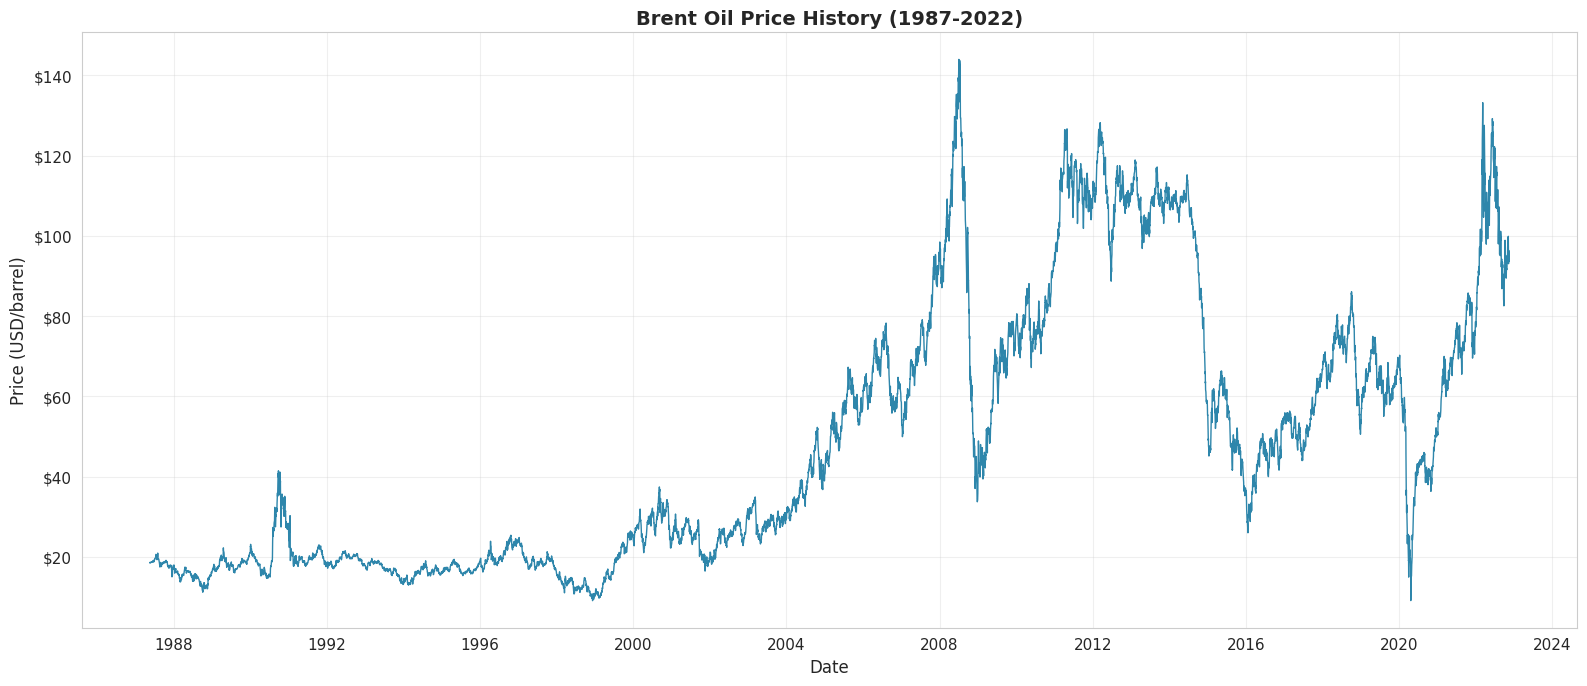


Key Observations:
• Long-term upward trend from 1987 to 2008 peak (~$144)
• 2008 financial crisis caused sharp decline
• Recovery period 2009-2014 with prices stabilizing around $100
• Major drop 2014-2016 (OPEC production strategy, oversupply)
• COVID-19 pandemic (2020) caused dramatic volatility
• Recent recovery and geopolitical tensions (2021-2022)


In [5]:
# Plot price series
fig = analyzer.plot_price_series(
    title='Brent Oil Price History (1987-2022)',
    figsize=(16, 7)
)

# Save figure
fig.savefig(figures_dir / '01_price_series.png', dpi=300, bbox_inches='tight')
print(f"✓ Figure saved: {figures_dir / '01_price_series.png'}")

plt.show()

# Key observations
print("\nKey Observations:")
print("• Long-term upward trend from 1987 to 2008 peak (~$144)")
print("• 2008 financial crisis caused sharp decline")
print("• Recovery period 2009-2014 with prices stabilizing around $100")
print("• Major drop 2014-2016 (OPEC production strategy, oversupply)")
print("• COVID-19 pandemic (2020) caused dramatic volatility")
print("• Recent recovery and geopolitical tensions (2021-2022)")

## 5. Log Returns Analysis

Calculate and analyze log returns, which are more suitable for statistical modeling than raw prices.

✓ Figure saved: ../reports/figures/02_log_returns.png


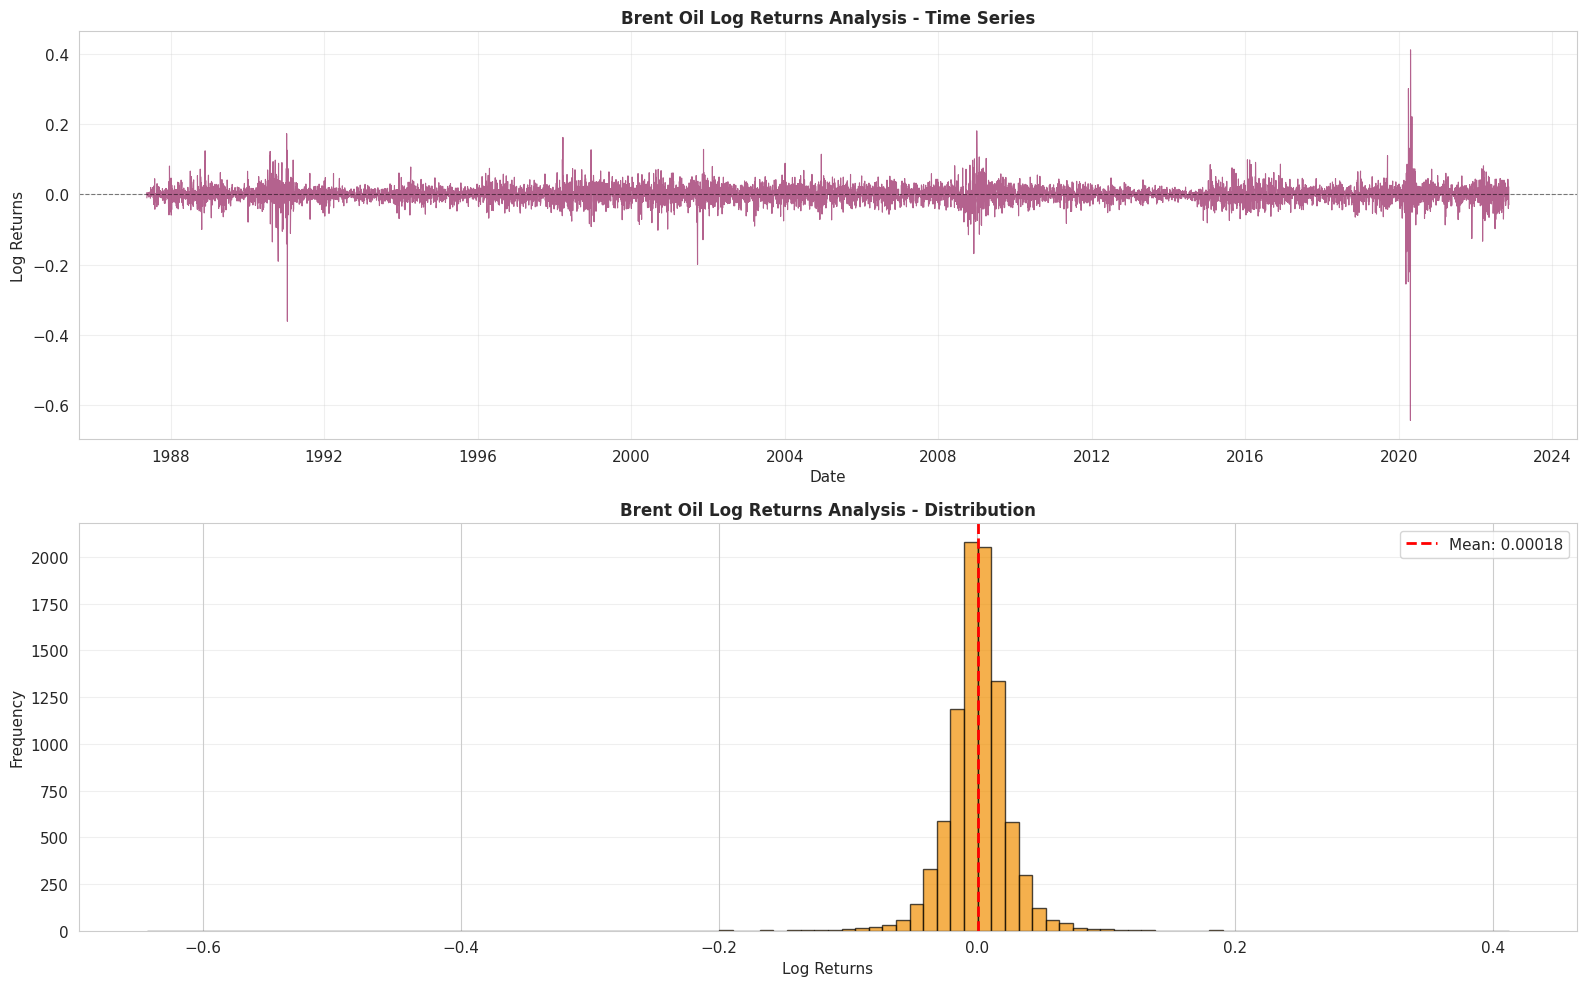


Extreme Returns (>0.0766 in absolute value):
Found 99 extreme events

Top 5 extreme drops:
Date
2020-04-21   -0.643699
1991-01-17   -0.361214
2020-03-09   -0.255175
2020-04-01   -0.248341
2020-04-09   -0.220471
Name: Price, dtype: float64

Top 5 extreme gains:
Date
2020-04-22    0.412023
2020-04-02    0.301613
2020-05-05    0.221574
2020-04-03    0.184049
2009-01-02    0.181297
Name: Price, dtype: float64


In [6]:
# Calculate log returns
log_returns = analyzer.calculate_log_returns()

# Plot log returns
fig = analyzer.plot_log_returns(
    title='Brent Oil Log Returns Analysis',
    figsize=(16, 10)
)

# Save figure
fig.savefig(figures_dir / '02_log_returns.png', dpi=300, bbox_inches='tight')
print(f"✓ Figure saved: {figures_dir / '02_log_returns.png'}")

plt.show()

# Identify extreme events
log_returns_clean = log_returns.dropna()
extreme_threshold = 3 * log_returns_clean.std()
extreme_returns = log_returns_clean[abs(log_returns_clean) > extreme_threshold]

print(f"\nExtreme Returns (>{extreme_threshold:.4f} in absolute value):")
print(f"Found {len(extreme_returns)} extreme events")
if len(extreme_returns) > 0:
    print("\nTop 5 extreme drops:")
    print(extreme_returns.nsmallest(5))
    print("\nTop 5 extreme gains:")
    print(extreme_returns.nlargest(5))

## 6. Volatility Analysis

Analyze volatility patterns using rolling statistics to identify periods of market turbulence.

✓ Figure saved: ../reports/figures/03_volatility_analysis.png


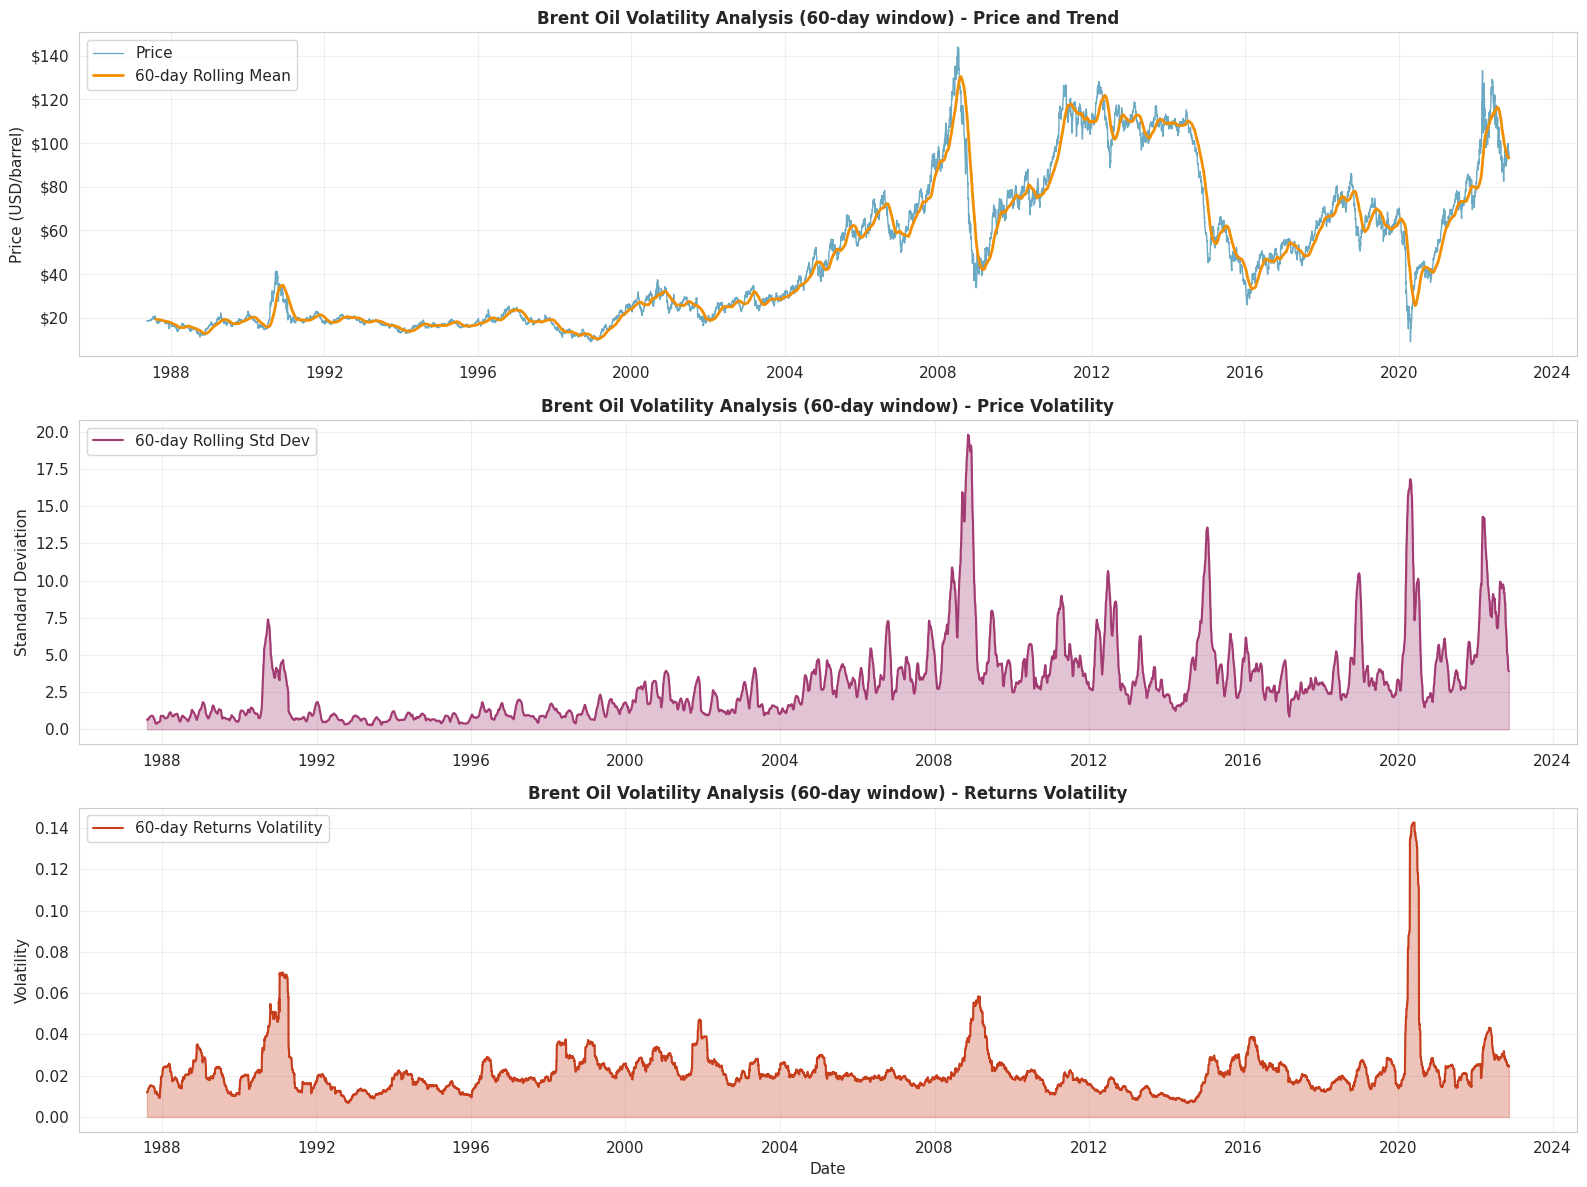


Volatility Observations:
• Volatility clustering: High volatility tends to follow high volatility
• Major volatility spikes correspond to:
  - 1990-1991: Gulf War
  - 2008-2009: Global Financial Crisis
  - 2014-2016: Oil price collapse
  - 2020: COVID-19 pandemic
• Periods of stability: Mid-1990s, 2010-2013, 2017-2019


In [7]:
# Plot volatility analysis with 60-day window
fig = analyzer.plot_volatility(
    window=60,
    title='Brent Oil Volatility Analysis (60-day window)',
    figsize=(16, 12)
)

# Save figure
fig.savefig(figures_dir / '03_volatility_analysis.png', dpi=300, bbox_inches='tight')
print(f"✓ Figure saved: {figures_dir / '03_volatility_analysis.png'}")

plt.show()

# Volatility observations
print("\nVolatility Observations:")
print("• Volatility clustering: High volatility tends to follow high volatility")
print("• Major volatility spikes correspond to:")
print("  - 1990-1991: Gulf War")
print("  - 2008-2009: Global Financial Crisis")
print("  - 2014-2016: Oil price collapse")
print("  - 2020: COVID-19 pandemic")
print("• Periods of stability: Mid-1990s, 2010-2013, 2017-2019")

## 7. Stationarity Testing

Test whether the price series and log returns are stationary using ADF and KPSS tests. This is crucial for determining whether change point modeling is appropriate.

In [8]:
# Create stationarity tester
tester = StationarityTester()

# Test original prices
print("=" * 80)
print("STATIONARITY TEST: BRENT OIL PRICES")
print("=" * 80)
price_results = tester.comprehensive_stationarity_test(
    data['Price'],
    series_name='Brent Oil Prices'
)

print(f"\n{price_results['conclusion']}")
print(f"\nRecommendation: {price_results['recommendation']}")

STATIONARITY TEST: BRENT OIL PRICES

Brent Oil Prices is NON-STATIONARY (both ADF and KPSS agree)

Recommendation: Apply differencing or other transformations (e.g., log returns) to achieve stationarity.


/home/voldi/Projects/ai-ml/brent-oil-change-point-analysis/src/statistical_tests/stationarity.py:169: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(clean_series, regression=regression, nlags=nlags)


In [9]:
# Test log returns
print("\n" + "=" * 80)
print("STATIONARITY TEST: LOG RETURNS")
print("=" * 80)
returns_results = tester.comprehensive_stationarity_test(
    log_returns.dropna(),
    series_name='Brent Oil Log Returns'
)

print(f"\n{returns_results['conclusion']}")
print(f"\nRecommendation: {returns_results['recommendation']}")


STATIONARITY TEST: LOG RETURNS

Brent Oil Log Returns is STATIONARY (both ADF and KPSS agree)

Recommendation: No transformation needed. Series is suitable for modeling.


/home/voldi/Projects/ai-ml/brent-oil-change-point-analysis/src/statistical_tests/stationarity.py:169: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(clean_series, regression=regression, nlags=nlags)


In [10]:
# Display detailed test results
print("\n" + "=" * 80)
print("DETAILED ADF TEST RESULTS")
print("=" * 80)

print("\nPrices:")
print(price_results['adf_interpretation'])

print("\nLog Returns:")
print(returns_results['adf_interpretation'])

print("\n\n" + "=" * 80)
print("DETAILED KPSS TEST RESULTS")
print("=" * 80)

print("\nPrices:")
print(price_results['kpss_interpretation'])

print("\nLog Returns:")
print(returns_results['kpss_interpretation'])


DETAILED ADF TEST RESULTS

Prices:
Augmented Dickey-Fuller (ADF) Test Results:
Test Statistic: -1.993856
P-value: 0.289274

Null Hypothesis (H0): Series has a unit root (non-stationary)
Alternative Hypothesis (H1): Series is stationary

✗ CONCLUSION: Fail to reject null hypothesis at 5.0% significance level
  → The series appears to be NON-STATIONARY
  → Evidence: p-value (0.289274) >= 0.05

  Recommendation: Consider differencing or transformation

Log Returns:
Augmented Dickey-Fuller (ADF) Test Results:
Test Statistic: -16.427113
P-value: 0.000000

Null Hypothesis (H0): Series has a unit root (non-stationary)
Alternative Hypothesis (H1): Series is stationary

✓ CONCLUSION: Reject null hypothesis at 5.0% significance level
  → The series appears to be STATIONARY
  → Evidence: p-value (0.000000) < 0.05


DETAILED KPSS TEST RESULTS

Prices:
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test Results:
Test Statistic: 9.558800
P-value: 0.010000

Null Hypothesis (H0): Series is stationary
Alter

## 8. Key Findings and Summary

Summarize the main findings from our exploratory data analysis.

In [11]:
# Generate comprehensive summary
print("=" * 80)
print("KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS")
print("=" * 80)

print("\n📊 DATA CHARACTERISTICS:")
print(f"  • {stats['data_info']['count']:,} daily observations from {stats['data_info']['date_range'][0]} to {stats['data_info']['date_range'][1]}")
print(f"  • Price range: ${stats['price_stats']['min']:.2f} - ${stats['price_stats']['max']:.2f}")
print(f"  • Mean price: ${stats['price_stats']['mean']:.2f}, Median: ${stats['price_stats']['median']:.2f}")

print("\n📈 PRICE BEHAVIOR:")
print(f"  • Non-stationary raw prices (confirmed by ADF and KPSS tests)")
print(f"  • Long-term upward trend with multiple structural breaks")
print(f"  • Major shifts in 1990-91, 2008, 2014-16, and 2020")

print("\n📉 RETURNS CHARACTERISTICS:")
print(f"  • Mean daily return: {stats['returns_stats']['mean_return']*100:.4f}%")
print(f"  • Daily volatility: {stats['returns_stats']['volatility']*100:.4f}%")
print(f"  • Annualized volatility: ~{stats['returns_stats']['volatility']*np.sqrt(252)*100:.1f}%")
print(f"  • Negative skewness ({stats['returns_stats']['skewness']:.2f}): More extreme negative returns")
print(f"  • High kurtosis ({stats['returns_stats']['kurtosis']:.1f}): Fat tails, extreme events common")
print(f"  • Log returns are STATIONARY (suitable for modeling)")

print("\n🌊 VOLATILITY PATTERNS:")
print("  • Strong volatility clustering observed")
print("  • High volatility periods correspond to:")
print("    - Geopolitical conflicts (Gulf War, Iraq War)")
print("    - Economic crises (2008 Financial Crisis, COVID-19)")
print("    - OPEC policy changes (2014-2016)")
print("  • Volatility varies from <1% to >10% daily during extreme events")

print(f"\n🌍 EVENTS IDENTIFIED:")
print(f"  • {event_summary['total_events']} major events catalogued")
print(f"  • Types: ", end="")
print(", ".join([f"{k}({v})" for k, v in event_summary['by_type'].items()]))
print("  • Events span geopolitical, economic, and policy domains")

print("\n✅ STATIONARITY ASSESSMENT:")
print("  • Raw prices: NON-STATIONARY (must transform)")
print("  • Log returns: STATIONARY (ready for change point modeling)")
print("  • Recommendation: Use log returns for Bayesian change point analysis")

print("\n🎯 IMPLICATIONS FOR ANALYSIS:")
print("  1. Use log returns (not raw prices) for change point modeling")
print("  2. Expect to detect multiple change points given visible structural breaks")
print(f"  3. High kurtosis ({stats['returns_stats']['kurtosis']:.1f}) suggests need for robust models or outlier handling")
print("  4. Volatility clustering may require GARCH-type extensions")
print("  5. Event associations should account for volatility persistence")

print(f"\n📁 OUTPUT:")
print(f"  • Figures saved to: {figures_dir.absolute()}")
print(f"  • 3 key visualizations created for reporting")

print("\n" + "=" * 80)
print("✓ EXPLORATORY DATA ANALYSIS COMPLETE")
print("=" * 80)

print("\nNext steps:")
print("1. Proceed to Bayesian change point modeling (Task 2)")
print("2. Use log returns as input to change point model")
print("3. Associate detected change points with events from our database")
print("4. Quantify impact magnitudes and directions")

KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS

📊 DATA CHARACTERISTICS:
  • 9,011 daily observations from 1987-05-20 to 2022-11-14
  • Price range: $9.10 - $143.95
  • Mean price: $48.42, Median: $38.57

📈 PRICE BEHAVIOR:
  • Non-stationary raw prices (confirmed by ADF and KPSS tests)
  • Long-term upward trend with multiple structural breaks
  • Major shifts in 1990-91, 2008, 2014-16, and 2020

📉 RETURNS CHARACTERISTICS:
  • Mean daily return: 0.0179%
  • Daily volatility: 2.5532%
  • Annualized volatility: ~40.5%
  • Negative skewness (-1.74): More extreme negative returns
  • High kurtosis (65.9): Fat tails, extreme events common
  • Log returns are STATIONARY (suitable for modeling)

🌊 VOLATILITY PATTERNS:
  • Strong volatility clustering observed
  • High volatility periods correspond to:
    - Geopolitical conflicts (Gulf War, Iraq War)
    - Economic crises (2008 Financial Crisis, COVID-19)
    - OPEC policy changes (2014-2016)
  • Volatility varies from <1% to >10% daily during ex